<a href="https://colab.research.google.com/github/ManikantaMandlem/Language-Modelling-using-LSTM/blob/main/NLP_test_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
params = dict()
params['emb_dim'] = 100
params['hidden_size'] = 100
params['n_layers'] = 2
params['dropout'] = 0.2
params['threshold'] = 3
params['seq_len'] = 30
params['clip_grad'] = 0.5
params['lr'] = 0.002
params['epochs'] = 20
params['train_batch_size'] = 20
params['model'] = 'lstm'
params['rnn_layers'] = 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchtext
import torch
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#train_file_path = '/content/drive/MyDrive/DL_NLP/assignment_2/wiki.train.txt'
#valid_file_path = '/content/drive/MyDrive/DL_NLP/assignment_2/wiki.valid.txt'
#test_file_path = '/content/drive/MyDrive/DL_NLP/assignment_2/wiki.test.txt'
train_file_path = '/content/drive/MyDrive/DL_NLP/wiki.train.txt'
valid_file_path = '/content/drive/MyDrive/DL_NLP/wiki.valid.txt'
test_file_path = '/content/drive/MyDrive/DL_NLP/wiki.test.txt'

In [ ]:
def ReadCorpus(file_name, words, vocab, params, src):
    if src == 0:
        temp = dict()
        last = 0
        total_tokens = 0
        with open(file_name, "r") as f:
            for line in f:
                #                line = line.replace(" "+chr(8211)+" "," - ")
                tokens = line.replace("\n", " </s> ").split()
                total_tokens = total_tokens + len(tokens)

                if (total_tokens - last) > 10000000:
                    print(total_tokens)
                    last = total_tokens

                for t in tokens:
                    if t == '"':
                        t = '<quote>'
                    try:
                        elem = temp[t]
                    except:
                        elem = [0, 0]
                    elem[1] = elem[1] + 1
                    temp[t] = elem

        wNextID = 0
        words = dict()
        words['<unk>'] = [wNextID, 0]
        wNextID = wNextID + 1

        for t in temp:
            elem = temp[t]
            if elem[1] >= params['threshold']:
                words[t] = [wNextID, elem[1]]
                wNextID = wNextID + 1

        vocab = list()
        vocab.append(' ')
        for w in words:
            vocab.append(' ')
        for w in words:
            elem = words[w]
            vocab[elem[0]] = w

    corpus = list()
    garbage = dict()

    last = 0
    total_tokens = 0
    with open(file_name, "r") as f:
        for line in f:
            #            line = line.replace(" "+chr(8211)+" "," - ")
            tokens = line.replace("\n", " </s> ").split()
            total_tokens = total_tokens + len(tokens)

            if (total_tokens - last) > 10000000:
                print(total_tokens)
                last = total_tokens

            for t in tokens:
                if t == '"':
                    t = '<quote>'
                try:
                    elem = words[t]
                except:
                    try:
                        g = garbage[t]
                    except:
                        g = 0
                    g = g + 1
                    garbage[t] = g
                    elem = words['<unk>']
                #                elem[1] = elem[1] + 1
                #                words[t] = elem
                corpus.append(elem[0])

    return corpus, words, vocab, garbage

In [ ]:
train, words, vocab, train_g=ReadCorpus(train_file_path, None, None, params, 0)
valid, words, _, valid_g=ReadCorpus(valid_file_path, words, vocab, params, 1)
test, words, __, test_g=ReadCorpus(test_file_path, words, vocab, params, 2)
train = torch.FloatTensor(train).to(device)
valid = torch.FloatTensor(valid).to(device)
test = torch.FloatTensor(test).to(device)

params['vocab_size'] = len(vocab)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, params):
        super(Model, self).__init__()
        self.lstm = torch.nn.LSTM(params['emb_dim'], params['hidden_size'], params['n_layers'], dropout = params['dropout'])
        self.vocab_size = params['vocab_size']

        self.embed_layer = torch.nn.Linear(params['hidden_size'], params['vocab_size'])
    
    def get_embedded(self, word_indexes):
        return self.embed_layer.weight.index_select(0, word_indexes)

    def forward(self, input):
        emb = torch.Tensor().to(device)
        shape0 = input.shape[0]
        shape1 = input.shape[1]
        for seq in input:
            emb = torch.cat((emb,self.get_embedded(seq.long())))

        emb = torch.reshape(emb, (shape0, shape1, params['emb_dim']))
        out, state = self.lstm(emb)

        logits = self.embed_layer(out)
        #probs = torch.nn.functional.log_softmax(logits)
        return logits

In [ ]:
class ModelRnn(torch.nn.Module):
    def __init__(self, params):
        super(ModelRnn, self).__init__()
        self.rnn = torch.nn.RNN(params['emb_dim'], params['hidden_size'], params['rnn_layers'], dropout = params['dropout'])

        self.hl1 = torch.nn.Linear(params['hidden_size'], params['hidden_size'])
        self.hl2 = torch.nn.Linear(params['hidden_size'], params['hidden_size'])

        self.vocab_size = params['vocab_size']

        self.embed_layer = torch.nn.Linear(params['hidden_size'], params['vocab_size'])
    
    def get_embedded(self, word_indexes):
        return self.embed_layer.weight.index_select(0, word_indexes)

    def forward(self, input):
        emb = torch.Tensor().to(device)
        shape0 = input.shape[0]
        shape1 = input.shape[1]
        for seq in input:
            emb = torch.cat((emb,self.get_embedded(seq.long())))

        emb = torch.reshape(emb, (shape0, shape1, params['emb_dim']))
        out, state = self.rnn(emb)

        out = self.hl1(out)
        out = torch.tanh(out)
        out = self.hl2(out)
        out = torch.tanh(out)

        logits = self.embed_layer(out)
        #logits = torch.nn.functional.log_softmax(logits)
        return logits

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    # def __len__(self):
    #     return (len(self.data)-self.seq_len)//self.seq_len

    # def __getitem__(self, index):
    #     offset = index*self.seq_len
    #     return (self.data[offset:offset+self.seq_len], self.data[offset+1:offset+self.seq_len+1])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return (self.data[index:index+self.seq_len], self.data[index+1:index+self.seq_len+1])



        anchor -> index

        prob:
            neg -> random.choice 

        prob:
            pos -> random.choice -> do augment 

In [ ]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.uniform_(m.weight, -0.1, 0.1)

In [ ]:
print(len(train))
train_dataset = Dataset(train, params['seq_len'])
valid_dataset = Dataset(valid, params['seq_len'])
test_dataset = Dataset(test, params['seq_len'])

2088628


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = params['train_batch_size']) #len(train)//20
valid_dataloader = DataLoader(valid_dataset, batch_size = params['train_batch_size'])
test_dataloader = DataLoader(test_dataset, batch_size = params['train_batch_size'])

In [ ]:
print(len(vocab))

33279




---





---
-----------------------LSTM Model-------------------------



In [ ]:
model = Model(params)

model.apply(init_weights)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), params['lr'])

In [ ]:
batch_loss_train = dict()
batch_perplexity_train = dict()
batch_loss_valid = dict()
batch_perplexity_valid = dict()
batch_loss_test = dict()
batch_perplexity_test = dict()
epoch_loss = dict()
epoch_perplexity = dict()


for i in range(params['epochs']):
    model.train()
    batch_loss_train[i] = []
    batch_perplexity_train[i] = []
    for batch, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        out = model(x)

        loss = criterion(torch.reshape(out, (-1, params['vocab_size'])), torch.squeeze(torch.reshape(y, (1, -1))).long())
        loss.backward()
        clip_grad_norm_(model.parameters(), params['clip_grad'])
        optimizer.step()

        batch_loss_train[i].append(loss.item())
        batch_perplexity_train[i].append(torch.exp(loss).item())

        if batch%100 == 0:

            #probs = torch.gather(out, dim=2, index=y.long().unsqueeze(dim=2))
            #probs = probs.squeeze(dim=2)
            perplexity = torch.exp(loss).item()

            print({ 'epoch': i, 'batch': batch, 'perplexity': perplexity, 'loss':loss.item()})

    model.eval()
    with torch.no_grad():
        batch_loss_valid[i] = []
        batch_perplexity_valid[i] = []
        batch_loss_test[i] = []
        batch_perplexity_test[i] = []

        for batch, (x, y) in enumerate(valid_dataloader):
            out = model(x)
            loss = criterion(torch.reshape(out, (-1, params['vocab_size'])), torch.squeeze(torch.reshape(y, (1, -1))).long())

            batch_loss_valid[i].append(loss.item())
            batch_perplexity_valid[i].append(torch.exp(loss).item())

        for batch, (x, y) in enumerate(test_dataloader):
            out = model(x)
            loss = criterion(torch.reshape(out, (-1, params['vocab_size'])), torch.squeeze(torch.reshape(y, (1, -1))).long())

            batch_loss_test[i].append(loss.item())
            batch_perplexity_test[i].append(torch.exp(loss).item())




{'epoch': 0, 'batch': 0, 'perplexity': 33712.3046875, 'loss': 10.425618171691895}
{'epoch': 0, 'batch': 100, 'perplexity': 3579.5693359375, 'loss': 8.182997703552246}
{'epoch': 0, 'batch': 200, 'perplexity': 877.8270874023438, 'loss': 6.777449607849121}
{'epoch': 0, 'batch': 300, 'perplexity': 1115.5057373046875, 'loss': 7.017063140869141}
{'epoch': 0, 'batch': 400, 'perplexity': 1603.5233154296875, 'loss': 7.379958629608154}
{'epoch': 0, 'batch': 500, 'perplexity': 741.7039184570312, 'loss': 6.608950138092041}
{'epoch': 0, 'batch': 600, 'perplexity': 2669.418701171875, 'loss': 7.889616012573242}
{'epoch': 0, 'batch': 700, 'perplexity': 2297.0419921875, 'loss': 7.739377498626709}
{'epoch': 0, 'batch': 800, 'perplexity': 857.076904296875, 'loss': 6.753527641296387}
{'epoch': 0, 'batch': 900, 'perplexity': 886.3443603515625, 'loss': 6.787105560302734}
{'epoch': 0, 'batch': 1000, 'perplexity': 1648.1302490234375, 'loss': 7.4073967933654785}
{'epoch': 0, 'batch': 1100, 'perplexity': 2782.3

In [ ]:
for i in range(params['epochs']):
    epoch_loss[i] = [torch.mean(torch.Tensor(batch_loss_train[i])), torch.mean(torch.Tensor(batch_loss_valid[i])), torch.mean(torch.Tensor(batch_loss_test[i]))]
    epoch_perplexity[i] = [torch.mean(torch.Tensor(batch_perplexity_train[i])), torch.mean(torch.Tensor(batch_perplexity_valid[i])), torch.mean(torch.Tensor(batch_perplexity_test[i]))]


In [ ]:
backup_lstm = [
batch_loss_train.copy(),
batch_perplexity_train.copy() ,
batch_loss_valid.copy() ,
batch_perplexity_valid.copy() ,
batch_loss_test.copy() ,
batch_perplexity_test.copy() ,
epoch_loss.copy() ,
epoch_perplexity.copy() ,
]

print(epoch_loss)
print(epoch_perplexity)

{0: [tensor(6.7815), tensor(6.0611), tensor(5.9860)], 1: [tensor(6.1027), tensor(5.8982), tensor(5.8198)], 2: [tensor(5.9031), tensor(5.8631), tensor(5.7809)], 3: [tensor(5.7876), tensor(5.8514), tensor(5.7669)], 4: [tensor(5.7030), tensor(5.8445), tensor(5.7564)], 5: [tensor(5.6375), tensor(5.8381), tensor(5.7475)], 6: [tensor(5.5810), tensor(5.8417), tensor(5.7504)], 7: [tensor(5.5321), tensor(5.8504), tensor(5.7597)], 8: [tensor(5.4931), tensor(5.8469), tensor(5.7557)], 9: [tensor(5.4628), tensor(5.8424), tensor(5.7493)], 10: [tensor(5.4329), tensor(5.8342), tensor(5.7417)], 11: [tensor(5.4097), tensor(5.8214), tensor(5.7284)], 12: [tensor(5.3862), tensor(5.8228), tensor(5.7306)], 13: [tensor(5.3718), tensor(5.8243), tensor(5.7319)], 14: [tensor(5.3542), tensor(5.8222), tensor(5.7286)], 15: [tensor(5.3381), tensor(5.8386), tensor(5.7447)], 16: [tensor(5.3251), tensor(5.8461), tensor(5.7514)], 17: [tensor(5.3159), tensor(5.8434), tensor(5.7514)], 18: [tensor(5.3054), tensor(5.8230), 

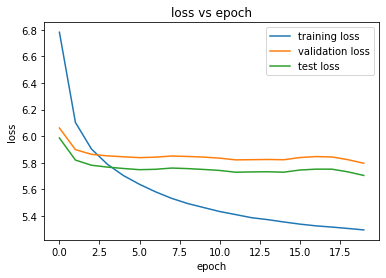

In [ ]:
epoch_loss = backup_lstm[-2]
epoch_perplexity = backup_lstm[-1]

plot_batch_perplexity = []
for key in batch_perplexity_train:
    plot_batch_perplexity.append(sum(batch_perplexity_train[key])/len(batch_perplexity_train[key]))
plt.plot(range(20),[epoch_loss[i][0] for i in epoch_loss.keys()],label = 'training loss')
plt.plot(range(20),[epoch_loss[i][1] for i in epoch_loss.keys()], label = 'validation loss')
plt.plot(range(20),[epoch_loss[i][2] for i in epoch_loss.keys()], label = 'test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend()
plt.show()

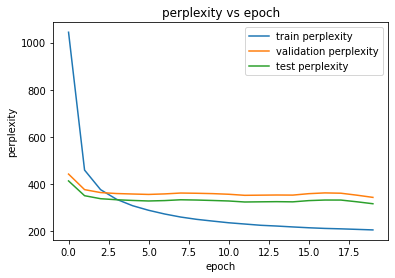

In [ ]:
plot_batch_perplexity = []
for key in batch_perplexity_train:
    plot_batch_perplexity.append(sum(batch_perplexity_train[key])/len(batch_perplexity_train[key]))
plt.plot(range(20),[epoch_perplexity[i][0] for i in epoch_perplexity.keys()],label = 'train perplexity')
plt.plot(range(20),[epoch_perplexity[i][1] for i in epoch_perplexity.keys()],label = 'validation perplexity')
plt.plot(range(20),[epoch_perplexity[i][2] for i in epoch_perplexity.keys()], label = 'test perplexity')
plt.xlabel('epoch')
plt.ylabel('perplexity')
plt.title('perplexity vs epoch')
plt.legend()
plt.show()



---
----------------------------RNN Model----------------------------


---




In [ ]:
params['dropout'] = 0.0 # no dropout for rnn model
model = ModelRnn(params)

model.apply(init_weights)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), params['lr'])

In [ ]:
batch_loss_train = dict()
batch_perplexity_train = dict()
batch_loss_valid = dict()
batch_perplexity_valid = dict()
batch_loss_test = dict()
batch_perplexity_test = dict()
epoch_loss = dict()
epoch_perplexity = dict()


for i in range(params['epochs']):
    model.train()
    batch_loss_train[i] = []
    batch_perplexity_train[i] = []
    for batch, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        out = model(x)

        loss = criterion(torch.reshape(out, (-1, params['vocab_size'])), torch.squeeze(torch.reshape(y, (1, -1))).long())
        loss.backward()
        clip_grad_norm_(model.parameters(), params['clip_grad'])
        optimizer.step()

        batch_loss_train[i].append(loss.item())
        batch_perplexity_train[i].append(torch.exp(loss).item())

        if batch%100 == 0:

            #probs = torch.gather(out, dim=2, index=y.long().unsqueeze(dim=2))
            #probs = probs.squeeze(dim=2)
            perplexity = torch.exp(loss).item()

            print({ 'epoch': i, 'batch': batch, 'perplexity': perplexity, 'loss':loss.item()})

    model.eval()
    with torch.no_grad():
        batch_loss_valid[i] = []
        batch_perplexity_valid[i] = []
        batch_loss_test[i] = []
        batch_perplexity_test[i] = []

        for batch, (x, y) in enumerate(valid_dataloader):
            out = model(x)
            loss = criterion(torch.reshape(out, (-1, params['vocab_size'])), torch.squeeze(torch.reshape(y, (1, -1))).long())

            batch_loss_valid[i].append(loss.item())
            batch_perplexity_valid[i].append(torch.exp(loss).item())

        for batch, (x, y) in enumerate(test_dataloader):
            out = model(x)
            loss = criterion(torch.reshape(out, (-1, params['vocab_size'])), torch.squeeze(torch.reshape(y, (1, -1))).long())

            batch_loss_test[i].append(loss.item())
            batch_perplexity_test[i].append(torch.exp(loss).item())


for i in range(params['epochs']):
    epoch_loss[i] = [torch.mean(torch.Tensor(batch_loss_train[i])), torch.mean(torch.Tensor(batch_loss_valid[i])), torch.mean(torch.Tensor(batch_loss_test[i]))]
    epoch_perplexity[i] = [torch.mean(torch.Tensor(batch_perplexity_train[i])), torch.mean(torch.Tensor(batch_perplexity_valid[i])), torch.mean(torch.Tensor(batch_perplexity_test[i]))]



{'epoch': 0, 'batch': 0, 'perplexity': 33723.26953125, 'loss': 10.425943374633789}
{'epoch': 0, 'batch': 100, 'perplexity': 2002.823974609375, 'loss': 7.60231351852417}
{'epoch': 0, 'batch': 200, 'perplexity': 2308.5068359375, 'loss': 7.744356155395508}
{'epoch': 0, 'batch': 300, 'perplexity': 1307.5419921875, 'loss': 7.175904273986816}
{'epoch': 0, 'batch': 400, 'perplexity': 1099.221435546875, 'loss': 7.002357482910156}
{'epoch': 0, 'batch': 500, 'perplexity': 1090.144775390625, 'loss': 6.994065761566162}
{'epoch': 0, 'batch': 600, 'perplexity': 799.0496215820312, 'loss': 6.683423042297363}
{'epoch': 0, 'batch': 700, 'perplexity': 780.0879516601562, 'loss': 6.659406661987305}
{'epoch': 0, 'batch': 800, 'perplexity': 503.3814697265625, 'loss': 6.221348285675049}
{'epoch': 0, 'batch': 900, 'perplexity': 1108.2354736328125, 'loss': 7.010524272918701}
{'epoch': 0, 'batch': 1000, 'perplexity': 792.7788696289062, 'loss': 6.675544261932373}
{'epoch': 0, 'batch': 1100, 'perplexity': 546.0344

In [ ]:
backup_rnn = [
batch_loss_train.copy(),
batch_perplexity_train.copy() ,
batch_loss_valid.copy() ,
batch_perplexity_valid.copy() ,
batch_loss_test.copy() ,
batch_perplexity_test.copy() ,
epoch_loss.copy() ,
epoch_perplexity.copy() ,
]

print(epoch_loss)
print(epoch_perplexity)

{0: [tensor(6.5204), tensor(5.9419), tensor(5.8653)], 1: [tensor(5.8801), tensor(5.8727), tensor(5.7911)], 2: [tensor(5.6614), tensor(5.8817), tensor(5.8000)], 3: [tensor(5.5368), tensor(5.9143), tensor(5.8324)], 4: [tensor(5.4597), tensor(5.9553), tensor(5.8762)], 5: [tensor(5.4125), tensor(5.9774), tensor(5.8926)], 6: [tensor(5.3770), tensor(5.9994), tensor(5.9143)], 7: [tensor(5.3504), tensor(6.0012), tensor(5.9163)], 8: [tensor(5.3225), tensor(6.0067), tensor(5.9209)], 9: [tensor(5.2990), tensor(6.0257), tensor(5.9436)], 10: [tensor(5.2799), tensor(6.0342), tensor(5.9538)], 11: [tensor(5.2653), tensor(6.0427), tensor(5.9568)], 12: [tensor(5.2515), tensor(6.0433), tensor(5.9613)], 13: [tensor(5.2432), tensor(6.0469), tensor(5.9603)], 14: [tensor(5.2316), tensor(6.0438), tensor(5.9587)], 15: [tensor(5.2194), tensor(6.0391), tensor(5.9472)], 16: [tensor(5.2131), tensor(6.0530), tensor(5.9617)], 17: [tensor(5.2065), tensor(6.0583), tensor(5.9674)], 18: [tensor(5.1987), tensor(6.0827), 

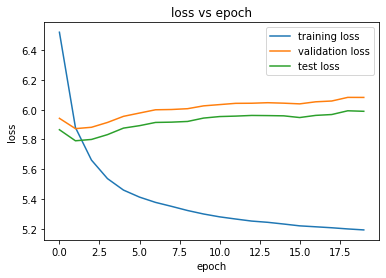

In [ ]:
epoch_loss = backup_rnn[-2]
epoch_perplexity = backup_rnn[-1]

plt.plot(range(20),[epoch_loss[i][0] for i in epoch_loss.keys()],label = 'training loss')
plt.plot(range(20),[epoch_loss[i][1] for i in epoch_loss.keys()], label = 'validation loss')
plt.plot(range(20),[epoch_loss[i][2] for i in epoch_loss.keys()], label = 'test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend()
plt.show()

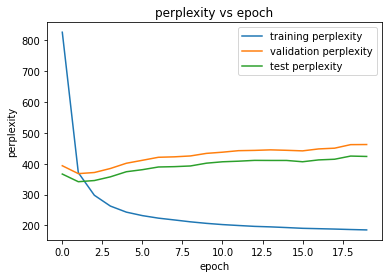

In [ ]:
plot_batch_perplexity = []
for key in batch_perplexity_train:
    plot_batch_perplexity.append(sum(batch_perplexity_train[key])/len(batch_perplexity_train[key]))
plt.plot(range(20),[epoch_perplexity[i][0] for i in epoch_perplexity.keys()], label = 'training perplexity')
plt.plot(range(20),[epoch_perplexity[i][1] for i in epoch_perplexity.keys()],label = 'validation perplexity')
plt.plot(range(20),[epoch_perplexity[i][2] for i in epoch_perplexity.keys()], label = 'test perplexity')
plt.xlabel('epoch')
plt.ylabel('perplexity')
plt.title('perplexity vs epoch')
plt.legend()
plt.show()